In [1]:
"""
A plot of samples drawn from a mixture of 3 Gaussians, with unit variance and significantly different means.
"""

'\nA plot of samples drawn from a mixture of 3 Gaussians, with unit variance and significantly different means.\n'

In [2]:
# This allows you to edit.g code in other files) without having to restart the kernel.
%load_ext autoreload 
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import random
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from src.smalldiffusion.model import TimeInputMLP
from src.smalldiffusion.diffusion import ScheduleLogLinear, training_loop, samples
from animations import animate_diffusion

/home/hepe00001/anaconda3/envs/generative_diffusion/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/hepe00001/anaconda3/envs/generative_diffusion/lib/python3.12/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [3]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def plot_batch(batch, filename, save=False):
    batch = batch.cpu().numpy()
    plt.scatter(batch[:,0], batch[:,1], marker='.')

    if save:
        # Save the plot to the specified path
        plt.savefig(filename)

    # Display the plot
    plt.show()
    
    # Close the plot to free up memory
    plt.close()

In [4]:
# Define mean and variance, where the variance is unit and the means are significantly different.
mean_1 = 0.0
variance_1 = 1.0

mean_2 = 20
variance_2 = 1.0

mean_3 = -20
variance_3 = 1.0

In [5]:
# Generate samples
samples_group_1 = np.random.normal(loc=mean_1, scale=variance_1**0.5, size=20)  
samples_group_2 = np.random.normal(loc=mean_2, scale=variance_2**0.5, size=20)  
samples_group_3 = np.random.normal(loc=mean_3, scale=variance_3**0.5, size=20)  

# concatenate them
samples_combined = []
samples_combined.extend(samples_group_1)
samples_combined.extend(samples_group_2)
samples_combined.extend(samples_group_3)

In [6]:
print(len(samples_combined))
print(samples_group_1)
print(samples_group_2)
print(samples_group_3)

60
[-0.57562883 -0.73194612 -0.26398716 -0.39984131 -0.42315069  0.18703618
 -1.02290218 -0.38727131  0.82376358  0.75662559  1.03879131  0.08230399
 -0.7639162   0.17540077 -0.93430568 -0.18252049  0.09541498  0.04115669
  0.25784215 -0.18594477]
[22.23248988 19.02554819 18.83452012 20.92173349 19.98008038 22.1413743
 19.91231268 19.89666801 21.01316327 19.07569577 17.34069258 21.04549338
 19.58588588 20.39121055 21.16872614 20.13629534 18.84517187 22.56720532
 21.12570475 20.03514521]
[-19.7007777  -19.32325018 -19.24190381 -19.12063907 -21.77399211
 -18.9757054  -20.39969027 -20.48347279 -18.76068127 -21.21555526
 -19.36988208 -20.83167364 -20.86574558 -18.21524975 -19.43758971
 -21.11951366 -20.24859436 -19.84951125 -20.15029388 -19.02252888]


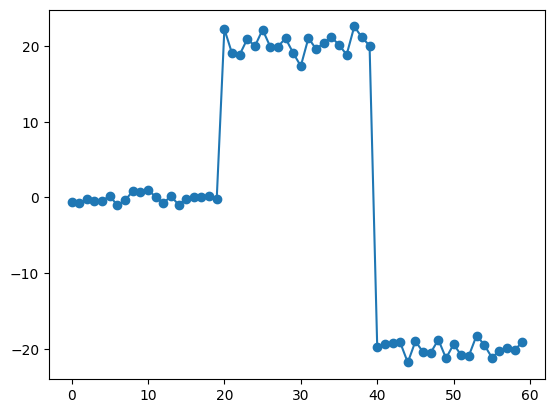

In [7]:
# Plot the values
plt.plot(samples_combined, marker='o')

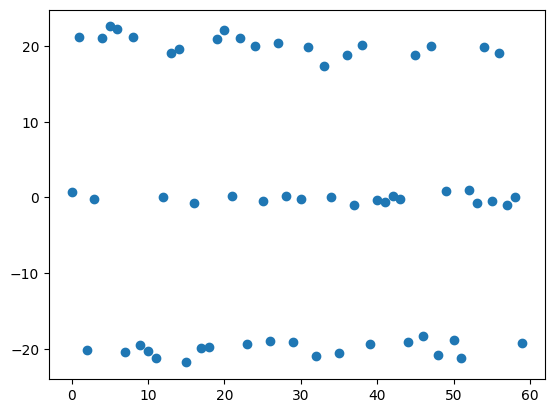

In [8]:
# Shuffle the list
shuffled_list = random.sample(samples_combined, len(samples_combined))

# Generate corresponding x-values
x_values = list(range(len(samples_combined)))

# Plot the values as points
plt.scatter(x_values, shuffled_list)

In [9]:
class GaussDistribution2D(Dataset):
    def __init__(self, mean, covariance_matrix, num_samples):

        # Sample from 3 different distributions
        samples_1 = np.random.multivariate_normal(mean[0], covariance_matrix, num_samples//3).astype(np.float32)
        samples_2 = np.random.multivariate_normal(mean[1], covariance_matrix, num_samples//3).astype(np.float32)
        samples_3 = np.random.multivariate_normal(mean[2], covariance_matrix, num_samples//3).astype(np.float32)

        samples_combined = []
        samples_combined.extend(samples_1)
        samples_combined.extend(samples_2)
        samples_combined.extend(samples_3)
        self.vals = samples_combined

    def __len__(self):
        return len(self.vals)

    def __getitem__(self, i):
        return self.vals[i]
    

In [10]:
mean = [[0,0], [20,20], [-20,-20]]
covariance_matrix = [[1.0, 0.0], [0.0, 1.0]]  # Zero covariance
num_samples = 100
dataset = GaussDistribution2D(mean, covariance_matrix, num_samples)

loader = DataLoader(dataset, batch_size=2048)



In [11]:
# input has 4 dimensions and output has 2 dimensions
model = TimeInputMLP(hidden_dims=(16,128,128,128,128,16))
print(model)

TimeInputMLP(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=16, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=16, out_features=128, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): GELU(approximate='none')
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): GELU(approximate='none')
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): GELU(approximate='none')
    (10): Linear(in_features=128, out_features=16, bias=True)
    (11): GELU(approximate='none')
    (12): Linear(in_features=16, out_features=2, bias=True)
  )
)


<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_3059122/3622150299.py:9: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sigma_t$')


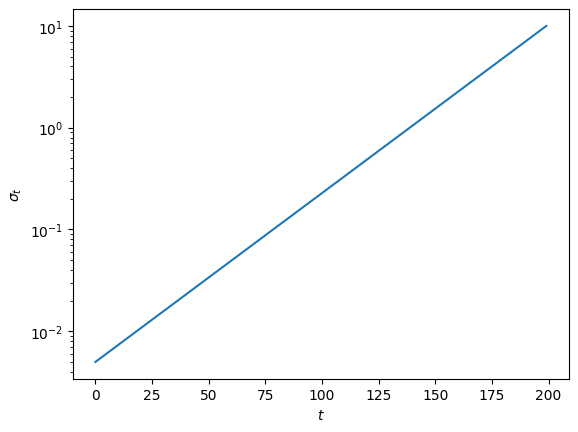

In [12]:
# the sigma values (or variance) in the context of diffusion models typically correspond to 
# the amount of noise added at each time step during the forward diffusion process.
# for this case, the lowest sigma (noise) is 0.005 and there are 200 sigma values
# that will gradually be added during the forward process

schedule = ScheduleLogLinear(N=200, sigma_min=0.005, sigma_max=10)
plt.plot(schedule.sigmas)
plt.xlabel('$t$')
plt.ylabel('$\sigma_t$')
plt.yscale('log')

<>:19: SyntaxWarning: invalid escape sequence '\s'
<>:20: SyntaxWarning: invalid escape sequence '\c'
<>:19: SyntaxWarning: invalid escape sequence '\s'
<>:20: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_3059122/2044932982.py:19: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(sx, label='$\sin(\log(\sigma_t)/2)$')
/tmp/ipykernel_3059122/2044932982.py:20: SyntaxWarning: invalid escape sequence '\c'
  plt.plot(sy, label='$\cos(\log(\sigma_t)/2)$')


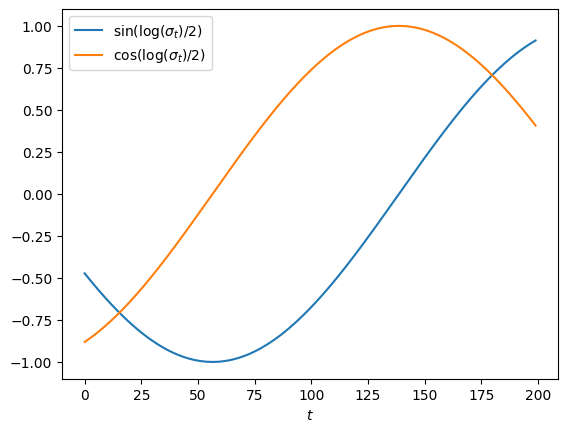

In [13]:
from src.smalldiffusion.model import get_sigma_embeds
"""
Sigma Embeddings
The sigma embeddings transform the sigma values into a form that the model can better utilize. 
This is done using sine and cosine functions of the logarithm of sigma. Here's why this is useful:

Purpose: The goal is to provide the model with a richer representation of the sigma value, 
         which represents the noise level. Instead of directly using sigma, which might 
         have a large dynamic range, the embeddings provide a bounded and periodic representation.

Transformation: By using sine and cosine of the logarithm of sigma, we capture both the scale (logarithm)
                and periodicity (sine and cosine) properties. This can help the model to learn more effectively, 
                especially when sigma varies widely.
"""

# schedule.sigmas is essentially 1D. however, get_sigma_embeds takes it to 2D
# where the first D is "torch.sin(torch.log(sigma)/2)" and the second D is "torch.cos(torch.log(sigma)/2)"
sx, sy = get_sigma_embeds(len(schedule), schedule.sigmas).T
plt.plot(sx, label='$\sin(\log(\sigma_t)/2)$')
plt.plot(sy, label='$\cos(\log(\sigma_t)/2)$')
plt.xlabel('$t$')
plt.legend()
plt.show()

In [14]:
# the next line is just creating the object
trainer  = training_loop(loader, model, schedule, epochs=1750)

losses   = [ns.loss.item() for ns in trainer]

100%|██████████| 1750/1750 [00:02<00:00, 598.69it/s]


1


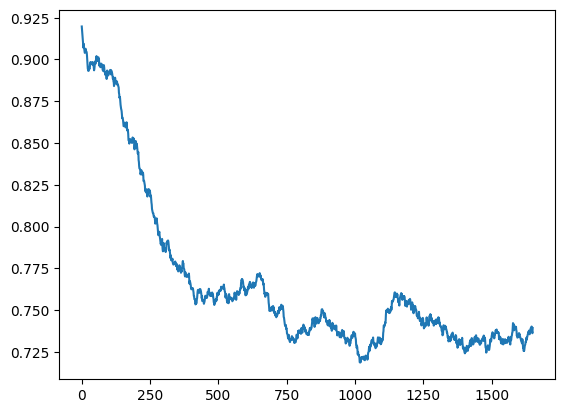

In [15]:
print(len(loader))
# plot the loss
plt.plot(moving_average(losses, 100))
plt.show()

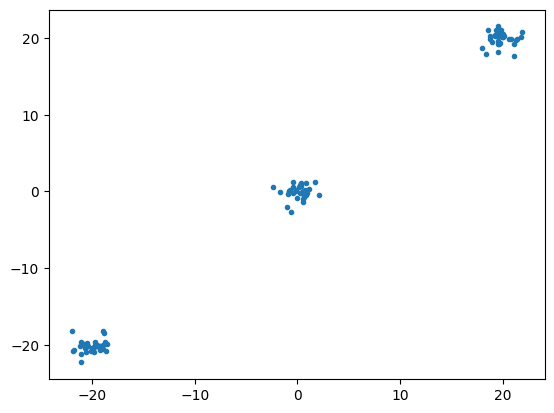

In [16]:
# all the instances in the data combined (plotted) together results
# in this 3 Gaussian shape. This is essentially the noiseless data that 
# represents the dataset
plot_batch(next(iter(loader)), filename="Gauss3", save=True)

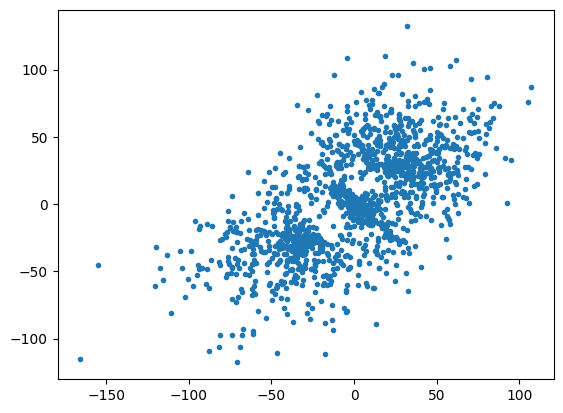

In [38]:
# generate batchsize data points given that amount of initial noise
#   DDPM       : gam=1, mu=0.5
#   DDIM       : gam=1, mu=0


xt = samples(model, schedule.sample_sigmas(133), mu=0.5, batchsize=1500)
# convert it to a list
denoising_steps = list(xt)
plot_batch(denoising_steps[132], filename="Gauss3_DDPM_250", save=False)


len(samples) 133


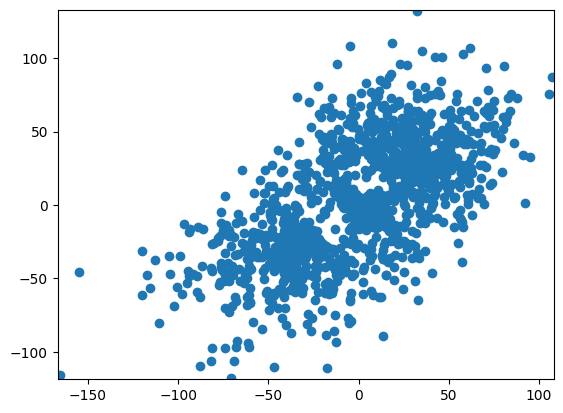

In [41]:
animate_diffusion(denoising_steps, filename="Gauss3_DDPM_250", save=False)